In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pingouin as pg
import warnings
warnings.filterwarnings("ignore")


sns.set(rc={'figure.figsize': (10, 6)})

In [3]:
# Считываем данные
df = pd.read_csv('KC_case_data.csv', parse_dates=['date'])

In [4]:
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [5]:
# Посмотрим на количество строк и столбцов
df.shape

(2747968, 8)

In [6]:
# Посмотрим на пропуски 
df.isna().sum()

date                  0
event                 0
purchase_sum    2606585
os_name               0
device_id             0
gender                0
city                  0
utm_source            0
dtype: int64

In [7]:
# Посмотрим на типы данных
df.dtypes

date            datetime64[ns]
event                   object
purchase_sum           float64
os_name                 object
device_id                int64
gender                  object
city                    object
utm_source              object
dtype: object

Text(0.5, 1.0, 'Распределение по городам')

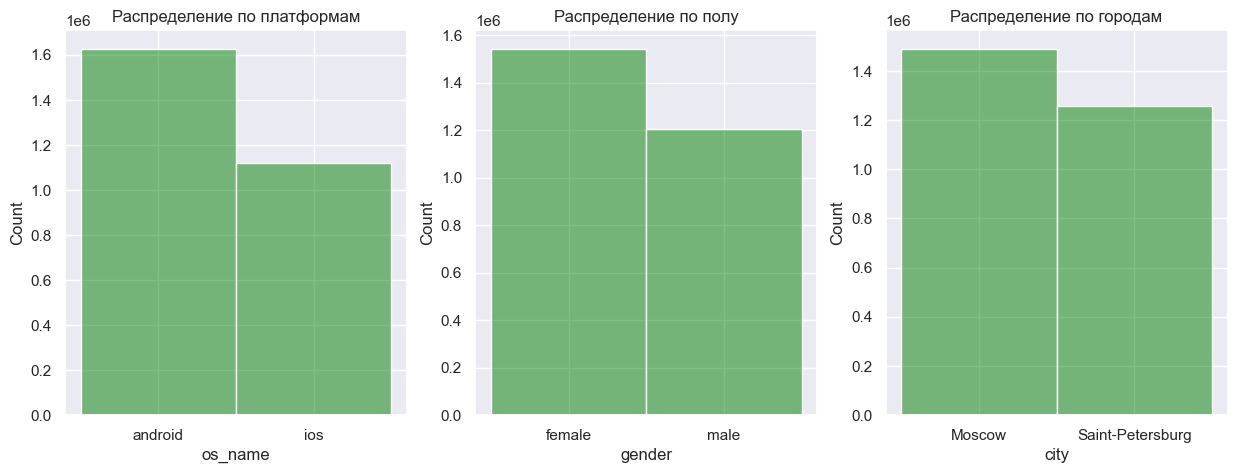

In [8]:
# Посмотрим на распределение пользователей по платформе, полу и городам
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

# Распределение по платформам
sns.histplot(df.os_name, color='green', alpha=0.5, ax=axs[0])
axs[0].set_title('Распределение по платформам')

# Распределение по полу
sns.histplot(df.gender, color='green', alpha=0.5, ax=axs[1])
axs[1].set_title('Распределение по полу')

# Распределение по городам
sns.histplot(df.city, color='green', alpha=0.5, ax=axs[2])
axs[2].set_title('Распределение по городам')

In [9]:
# С помощью многофакторного дисперсионного анализа можно посмотреть влияние факторов (платформа, пол и город) на сумму трат.
pg.anova(data=df[df.purchase_sum.notna()], dv='purchase_sum', between=['os_name', 'gender', 'city'])

,Source,SS,DF,MS,F,p-unc,np2
0,os_name,3.621974e+04,1.0,3.621974e+04,0.021783,0.882667,1.540780e-07
1,gender,5.995796e+04,1.0,5.995796e+04,0.036059,0.849394,2.550598e-07
2,city,2.193665e+05,1.0,2.193665e+05,0.131928,0.716441,9.331797e-07
3,os_name * gender,3.998545e+04,1.0,3.998545e+04,0.024047,0.876764,1.700972e-07
4,os_name * city,5.060708e+04,1.0,5.060708e+04,0.030435,0.861506,2.152814e-07
5,gender * city,6.060130e+05,1.0,6.060130e+05,0.364460,0.546041,2.577960e-06
6,os_name * gender * city,1.082008e+06,1.0,1.082008e+06,0.650726,0.419855,4.602816e-06
7,Residual,2.350741e+11,141375.0,1.662770e+06,NaN,NaN,NaN


In [10]:
# Исследуемые факторы (платформа, пол и город) не оказали значимого влияния.

<Axes: xlabel='utm_source', ylabel='purchase_sum'>

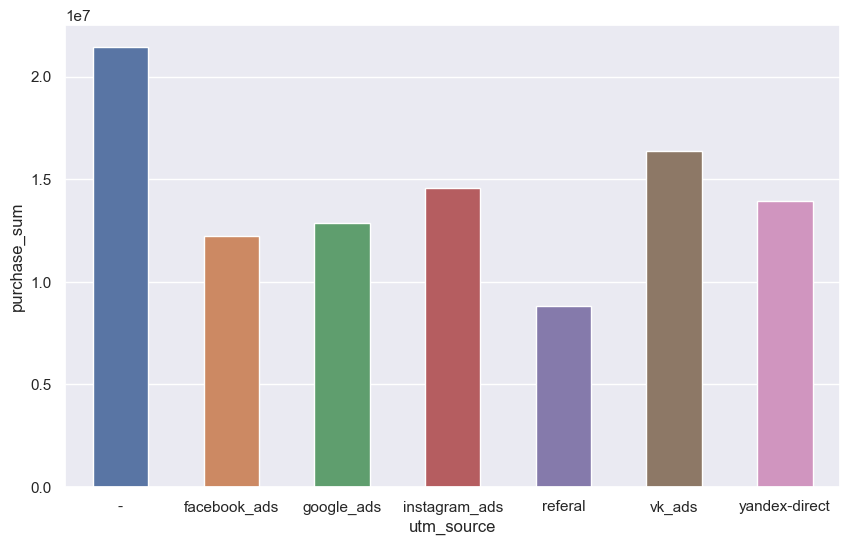

In [11]:
# Посмотрим какие рекламные компании принесли больше всего дохода с пользователей
df1 = df.groupby('utm_source')['purchase_sum'].sum().reset_index()
sns.barplot(x='utm_source', y='purchase_sum', width=0.5, data=df1)

In [12]:
# Создадим новую колонку и поместим туда номер месяца
df['month'] = df['date'].dt.month

In [13]:
# Посчитаем MAU 
df.groupby('month').agg({'device_id': 'nunique'}).reset_index()

,month,device_id
0,1,99161
1,2,75032
2,3,74623


<Axes: xlabel='month', ylabel='device_id'>

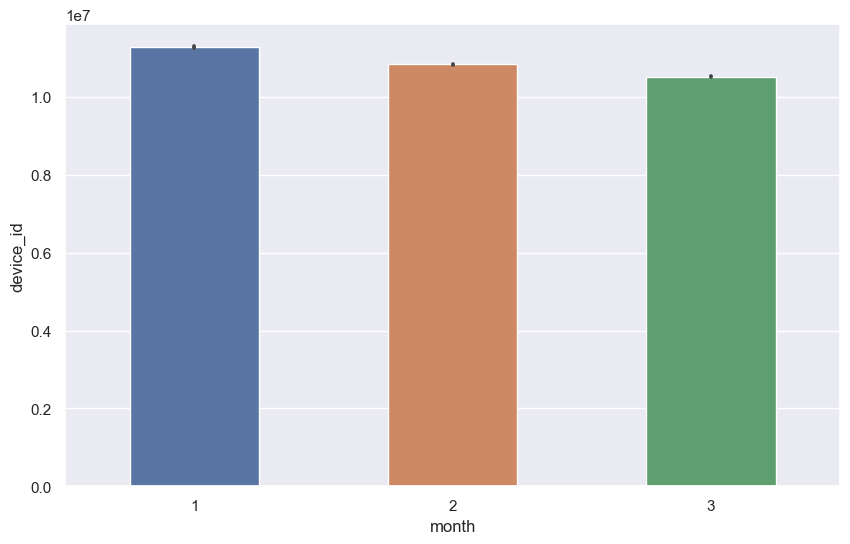

In [14]:
# Визуализируем MAU
sns.barplot(x='month', y='device_id', width=0.5, data=df)

In [15]:
# Посчитаем DAU 
dau = df.groupby('date').agg({'device_id': 'nunique'}).reset_index()

In [16]:
dau.head()

,date,device_id
0,2020-01-01,4445
1,2020-01-02,5104
2,2020-01-03,5144
3,2020-01-04,4925
4,2020-01-05,5608


<Axes: xlabel='date', ylabel='device_id'>

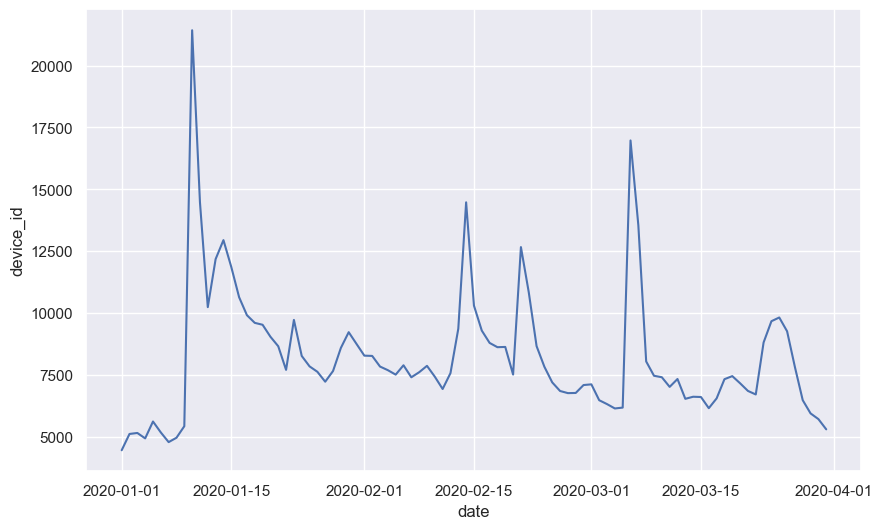

In [17]:
# Визуализируем количество уникальных пользователей по датам
sns.lineplot(x='date', y='device_id', data=dau)

In [18]:
# На графике есть скачки.
# Посмотрим на описательные статистики
dau.describe()

,device_id
count,91.000000
mean,8228.890110
std,2671.593259
min,4445.000000
25%,6728.000000
50%,7618.000000
75%,9128.000000
max,21431.000000


In [19]:
# Посмотрим в какой день DAU было максимальным
dau.query('device_id == 21431')

,date,device_id
9,2020-01-10,21431


In [20]:
# Посмотрим в какой день DAU было минимальным
dau.query('device_id == 4445')

,date,device_id
0,2020-01-01,4445


In [21]:
# Посчитаем ARPU за весь период
ARPU = round(df['purchase_sum'].sum() / df['device_id'].nunique(), 2)
ARPU 

525.22

In [22]:
# Посчитаем ARPPU за весь период
ARPPU = round(df['purchase_sum'].sum() / df[df.purchase_sum.notna()]['device_id'].nunique(), 2)
ARPPU

1414.56

In [42]:
# Посмотрим на конверсию воронки продаж
first_reg = df.query('event == "register"').sort_values('date').drop_duplicates('device_id')

In [43]:
df['first_reg'] = df['device_id'].map(first_reg.set_index('device_id')['date'])

In [25]:
already_reg = df[df.first_reg < df.date]

In [26]:
already_reg = already_reg.groupby('event')['device_id'].nunique().reset_index().set_index('event')

In [27]:
already_reg = already_reg.T

In [28]:
already_reg

event,app_start,choose_item,purchase,search,tap_basket
device_id,40991,37926,24880,40482,34517


In [29]:
print('Конверсия в поиск из открытия приложения', round(already_reg['search'] / already_reg['app_start'], 2))

Конверсия в поиск из в открытия приложения device_id    0.99
dtype: float64


In [235]:
print('Конверсия из поиска в выбор товара', round(already_reg['choose_item'] / already_reg['search'], 2))

Конверсия из поиска в выбор товара device_id    0.94
dtype: float64


In [30]:
print('Конверсия из выбора товара в добавление в корзину', round(already_reg['tap_basket'] / already_reg['choose_item'], 2))

Конверсия из выбора товара в добавление в корзину device_id    0.91
dtype: float64


In [31]:
print('Конверсия в покупку из добавления в корзину', round(already_reg['purchase'] / already_reg['tap_basket'], 2))

Конверсия в покупку из добавления в корзину device_id    0.72
dtype: float64


In [244]:
# Самый маленький СR в покупку из добавления в корзину

Имеются данные по затратам на рекламу:
1. Яндекс – 10 491 707 руб.
2. Гугл – 10 534 878 руб.
3. Фейсбук – 8 590 498 руб.
4. Инстаграм – 8 561626 руб.
5. ВК – 9 553 531руб.

In [32]:
# Сгруппируем данные по каналу привлечения и посчитаем доход.
df.groupby('utm_source')['purchase_sum'].sum()

utm_source
-                21449749.5
facebook_ads     12249901.0
google_ads       12868276.0
instagram_ads    14546969.0
referal           8837044.5
vk_ads           16389652.5
yandex-direct    13915368.0
Name: purchase_sum, dtype: float64

In [41]:
# Посчитаем ROMI для каждого платного канала
print('ROMI facebook_ads', round((12249901 - 8590498)/8590498*100, 2),"%")
print('ROMI google_ads', round((12868276 - 10534878)/10534878*100, 2), "%")
print('ROMI instagram_ads', round((14546969 - 8561626)/8561626*100, 2), "%")
print('ROMI vk_ads', round((16389652.5 - 9553531)/9553531*100, 2), "%")

ROMI facebook_ads равен 42.6 %
ROMI google_ads 22.15 %
ROMI instagram_ads 69.91 %
ROMI vk_ads 71.56 %


In [ ]:
# Посчитаем CPA и CAC

In [59]:
print('CPA yandex-direct', round((10491707)/df.query('utm_source == "yandex-direct"')['device_id'].nunique(), 2))
print('CPA google_ads ', round((10534878)/df.query('utm_source == "google_ads"')['device_id'].nunique(), 2))
print('CPA facebook_ads ', round((8590498)/df.query('utm_source == "facebook_ads"')['device_id'].nunique(), 2))
print('CPA instagram_ads ', round((8561626)/df.query('utm_source == "instagram_ads"')['device_id'].nunique(), 2))
print('CPA vk_ads', round((9553531)/df.query('utm_source == "vk_ads"')['device_id'].nunique(), 2))

CPA yandex-direct 257.71
CPA google_ads  276.54
CPA facebook_ads  330.93
CPA instagram_ads  275.75
CPA vk_ads 280.28


In [60]:
print('CAC yandex-direct', round((10491707)/df[df.purchase_sum.notna()]
                                 .query('utm_source == "yandex-direct"')['device_id'].nunique(), 2))
print('CAC google_ads', round((10534878)/df[df.purchase_sum.notna()]
                                 .query('utm_source == "yandex-direct"')['device_id'].nunique(), 2))
print('CAC facebook_ads', round((8590498)/df[df.purchase_sum.notna()]
                                 .query('utm_source == "yandex-direct"')['device_id'].nunique(), 2))
print('CAC instagram_ads', round((8561626)/df[df.purchase_sum.notna()]
                                 .query('utm_source == "yandex-direct"')['device_id'].nunique(), 2))
print('CAC vk_ads', round((9553531)/df[df.purchase_sum.notna()]
                                 .query('utm_source == "yandex-direct"')['device_id'].nunique(), 2))

CAC yandex-direct 872.27
CAC google_ads 875.86
CAC facebook_ads 714.21
CAC instagram_ads 711.81
CAC vk_ads 794.27


Выводы:
1. В январе по сравнению с февралем и мартом самое высокое значение MAU.
2. Минимальное значение DAU 1 января, что объясняется началом выходных и праздничных дней, а скачок DAU 10 января совпадает с окончанием зимних каникул.
3. Такие факторы как: платформа, пол и город, а также их взаимодействие не оказали значимого влияния на сумму трат клиентов.
4. ARPU и ARPPU составили 525.22 и 1414.56 соответственно.
5. Больше всего дохода (из платных источников) принесли клиенты, пришедшие из рекламы в ВК, а меньше всего клиенты, пришедшие с акции "приведи друга".
6. Самый маленький СR в покупку из добавления в корзину.
7. Самое высокое значение ROMI у канала ВК.
8. По метрике CPA самый эффективный канал привлечения Яндекс, по CAC инстаграм.